# Agentic RAG (Self-RAG)

## Setting
 - Auto Reload
 - path for utils

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [4]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [5]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-7-Sonnet-CRI': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Comma

## 2. LLM, Embedding model 정의

In [6]:
from utils.bedrock import bedrock_model
from langchain_aws import BedrockEmbeddings
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [7]:
llm = bedrock_model(
    #model_id=bedrock_info.get_model_id(model_name="Claude-V3-7-Sonnet-CRI"),
    model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
    }
)

In [8]:
emb = BedrockEmbeddings(client=boto3_bedrock, model_id = "amazon.titan-embed-text-v2:0")
dimension = 1024

## 3. Vector store

In [9]:
import boto3
from utils.ssm import parameter_store

In [10]:
region=boto3.Session().region_name
pm = parameter_store(region)

### 3.1 Get index name

In [11]:
opensearch_domain_endpoint = pm.get_params(key="opensearch_domain_endpoint", enc=False)
opensearch_user_id = pm.get_params(key="opensearch_user_id", enc=False)
opensearch_user_password = pm.get_params(key="opensearch_user_password", enc=True)

http_auth = (opensearch_user_id, opensearch_user_password) # Master username, Master password
#index_name = opensearch_user_password = pm.get_params(key="opensearch_index_name", enc=True)
index_name = "idx-genai-contextual-retriever"
print (f'index_name: {index_name}')

index_name: idx-genai-contextual-retriever


### 3.2 Get opensearch client

In [12]:
from utils.opensearch import opensearch_utils

In [13]:
os_client = opensearch_utils.create_aws_opensearch_client(region, opensearch_domain_endpoint, http_auth)

## 4. Agents

In [14]:
import time
import json
import pprint
from termcolor import colored

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict, List
from src.genai_analysis import llm_call
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

from utils.common_utils import retry
from utils.agentic_rag import OpenSearchHybridSearchRetriever, show_context_used
from botocore.exceptions import ClientError, ConnectionError, ConnectTimeoutError, ReadTimeoutError

In [15]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

### 4.1 Agent state 

In [16]:
class GraphState(TypedDict):
    query: str
    documents: List[str]
    generation: str

In [36]:
class self_rag():

    def __init__(self, **kwargs):

        self.timer = TimeMeasurement()
        
        self.llm, self.emb = kwargs["llm"], kwargs["emb"]
        os_client, index_name = kwargs["os_client"], kwargs["index_name"]
        self.query_regeneration_limit = kwargs["query_regeneration_limit"]
        self.state = GraphState

        self.retriever = self.get_retriever(os_client=os_client, index_name=index_name)        

        self._graph_definition()
        self.messages = []
        self.contexts = []
        self.generation = ""

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
            
    def get_messages(self, ):
        return self.messages

    def get_retriever(self, **kwargs):

        os_client, index_name = kwargs["os_client"], kwargs["index_name"]
        
        opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
            os_client=os_client,
            index_name=index_name,
            llm_text=self.llm, # llm for query augmentation in both rag_fusion and HyDE
            llm_emb=self.emb, # Used in semantic search based on opensearch 
        
            # hybird-search debugger
            hybrid_search_debugger="None", #[semantic, lexical, None]
            
            # option for lexical
            minimum_should_match=0,
            filter=[],
        
            # option for search
            fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
            ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
            reranker=True, # enable reranker with reranker model
            reranker_endpoint_name="cohere-reranker-3-5", # endpoint name for reranking model
            parent_document=False, # enable parent document
                        
            # option for complex documents consisting of text, table and image
            complex_doc=False,
            
            # option for async search
            async_mode=True,
        
            # option for output
            k=3, # 최종 Document 수 정의
            verbose=True,
        )

        return opensearch_hybrid_retriever
            
    @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(ClientError,))
    def rag_chain(self, **kwargs):

        query, documents = kwargs["query"], kwargs["documents"]
        messages = []
        
        self.llm.stream = True
        llm_caller = llm_call(llm=self.llm, verbose=False)

        system_prompts = dedent(
            '''
            You are an assistant for question-answering tasks.
            Use the following pieces of retrieved documents to answer the question.
            Skip the preamble and go straight into the answer.
            If you don't know the answer, just say that you don't know.
            '''
        )
  
        system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
        user_prompts = dedent(
            '''
            Documents: <documents>{documents}</documents>
            User question: <question>{query}</question>
            '''
        )        

        reformat_documents = "\n\n".join(doc.page_content for doc in documents)
        context = {"documents": reformat_documents, "query": query}
        user_prompts = user_prompts.format(**context)
                   
        message = self._get_message_from_string(role="user", string=user_prompts)
        self.messages.append(message)
        resp, ai_message = llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
        self.messages.append(ai_message)

        return resp["text"]
        
    def _graph_definition(self, **kwargs):

        def retrieve(state):
            """
            Retrieve documents
        
            Args:
                state (dict): The current graph state
        
            Returns:
                state (dict): New key added to state, documents, that contains retrieved documents
            """
            print("---RETRIEVE---")
            query = state["query"]
        
            # Retrieval
            if self.retriever.complex_doc: documents, tables, images = self.retriever.invoke(query)
            else: documents = self.retriever.invoke(query)
            
            self.contexts = documents

            return {"documents": documents, "query": query}
        
        def generate(state):
            """
            Generate answer
        
            Args:
                state (dict): The current graph state
        
            Returns:
                state (dict): New key added to state, generation, that contains LLM generation
            """
            print("---GENERATE---")
            query, documents = state["query"], state["documents"]
            feedback = state.get("feedback", None)
            
            # RbAG generation
            generation = self.rag_chain(query=query, documents=documents)
            self.generation = generation
            
            query_revision_count = state.get("query_revision_count", 0)
            query_revision_count = 0
            
            return {"documents": documents, "query": query, "generation": generation, "query_revision_count": query_revision_count}    
            
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("retrieve", retrieve)
        workflow.add_node("generate", generate)
        
        workflow.add_edge(START, "retrieve")
        workflow.add_edge("retrieve", "generate")
        workflow.add_edge("generate", END)
        #workflow.add_edge("retrieve", END)

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "advanced_rag"})

    def invoke(self, **kwargs):
        
        inputs = self.state(query=kwargs["query"])
        
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                print(f"\nOutput from node '{key}':")
                #print("---")
                
                #print (self.messages)
                # 출력 값을 예쁘게 출력합니다.
                #pprint.pprint(value, indent=2, width=80, depth=None)
                
            # 각 출력 사이에 구분선을 추가합니다.
            print("\n-------------------------------------------------------\n")

        print("---Answer---")
        print(colored(self.generation, "green"))
        print("---Contexts---")
        show_context_used(self.contexts)
            
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            display(Image(self.app.get_graph(xray=True).draw_mermaid_png()))  
        except (Exception) as e:
            print (e)
            pass


In [37]:
rag_client = self_rag(
    llm=llm,
    emb=emb,
    os_client=os_client,
    index_name=index_name,
    query_regeneration_limit=2
)

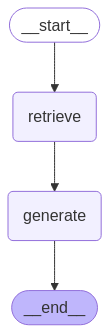

In [38]:
rag_client.show_graph()

In [39]:
rag_client.invoke(
    query="trial license device number"
    
    #It explains that the trial license covers up to 30 active devices and expires after 3 months.
)

INFO:retry-bedrock-invocation:trying rag_chain() [1/5]


---RETRIEVE---
##############################
async_mode
##############################
True
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
False
##############################
HyDE
##############################
False
##############################
parent_document
##############################
False
##############################
complex_document
##############################
False
##############################
similar_docs_semantic
##############################

Score: 1.0
['Context:', 'This chunk provides an overview of a common issue where a Knox Suite trial license is assigned to Enterprise Edition or Verizon Enterprise Edition devices instead of the expected commercial license. It explains that the trial license needs to be replaced with the appropriate commercial license, and directs the reader to follow the resolution steps provided in the document.', '', 'Chunk:', 'title: 

INFO:retry-bedrock-invocation:in retry(), rag_chain() returned 'The trial license covers up to 30 active devices.'



Output from node 'generate':

-------------------------------------------------------

---Answer---
The trial license covers up to 30 active devices.
---Contexts---

-----------------------------------------------
1. Chunk: 1033 Characters
-----------------------------------------------
Context:
This chunk provides the explanation for why a Knox Suite trial license may be assigned to Enterprise
Edition and Verizon Enterprise Edition devices, even though these device bundles come with
commercial license keys. It explains that the trial license is automatically added to new Knox
accounts, and if it is not deleted, it will be assigned to devices upon enrollment, despite the
commercial licenses available for those device bundles.

Chunk:
title: Knox Suite trial license assigned to devices purchased as a bundle : Cause
Upon first signing up for a Samsung Knox account, a free 90-day Knox Suite trial license is
automatically added to your account on the Knox Admin Portal.

However, trial lic